### Traveling Salesperson Problem (TSP) using QAOA with Qiskit

This tutorial will guide you through solving the Traveling Salesperson Problem (TSP), a classic optimization challenge, using the Quantum Approximate Optimization Algorithm (QAOA). We'll follow a standard process: setting up the TSP instance in Qiskit, converting it into a quantum-compatible format, and then applying QAOA to find an approximate solution for the optimal tour.

In [352]:
import qiskit
print(qiskit.__version__)

1.3.1


### Travelling Salesman Problem

The TSP on the nodes of a graph asks for the shortest **Hamiltonian cycle** that can be taken through each of the nodes. A Hamiltonian cycle is a closed path that uses every vertex of a graph once. The general solution is unknown, and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

<!-- ### Mathematical Formulation

Find the shortest Hamiltonian cycle in a graph $ G = (V, E) $ with $ n = |V| $ nodes and distances $ w_{ij} $ (distance from vertex $ i $ to vertex $ j $). A Hamiltonian cycle is described by $ N^2 $ variables $ x_{i,p} $, where $ i $ represents the node and $ p $ represents its order in a prospective cycle. The decision variable takes the value $ 1 $ if the solution occurs at node $ i $ at time order $ p $. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summations run over $ 0, 1, \dots, N-1 $):

$$
\sum_i x_{i,p} = 1 \quad \forall p
$$

$$
\sum_p x_{i,p} = 1 \quad \forall i.
$$

For nodes in our prospective ordering, if $ x_{i,p} $ and $ x_{j,p+1} $ are both $ 1 $, then there should be an energy penalty if $ (i, j) \notin E $ (not connected in the graph). The form of this penalty is:

$$
\sum_{i,j \notin E} \sum_p x_{i,p} x_{j,p+1} > 0,
$$

where it is assumed the boundary condition of the Hamiltonian cycles ($ p = N $) $ \equiv (p = 0) $. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is:

$$
C(\mathbf{x}) = \sum_{i,j} w_{ij} \sum_p x_{i,p} x_{j,p+1}.
$$

Putting this all together in a single objective function to be minimized, we get the following:

$$
C(\mathbf{x}) = \sum_{i,j} w_{ij} \sum_p x_{i,p} x_{j,p+1} + A \sum_p \left( 1 - \sum_i x_{i,p} \right)^2 + A \sum_i \left( 1 - \sum_p x_{i,p} \right)^2,
$$

where $ A $ is a free parameter. One needs to ensure that $ A $ is large enough so that these constraints are respected. One way to do this is to choose $ A $ such that $ A > \max(w_{ij}) $. -->

### Setting Up the Environment

Before we define the problem, we need to import the necessary libraries. These include:

- **Basic libraries:** numpy for numerical operations and matplotlib for plotting.

- **Qiskit Optimization:** Tools to define the Knapsack problem (Knapsack), convert it into a quadratic program, and map it to a quantum problem (QuadraticProgramToQubo).

- **Qiskit Algorithms:** The core QAOA components, including the Estimator primitive for calculating expectation values and the EfficientSU2 ansatz.

- **SciPy:** A classical optimizer that QAOA will use to minimize the cost function.

- **Qiskit Aer:** To simulate a quantum backend for our experiment.

In [353]:
# --- Basic and Visualization Imports ---
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from docplex.mp.model import Model
# --- Qiskit and Optimization Imports ---
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

backend = AerSimulator(method='automatic')   # if you want to run bigger circuits, you can use 'matrix_product_state' or 'statevector' method
# backend = AerSimulator(method='statevector')  # for smaller circuits, this is faster

estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)


### Generate a Random TSP Instance



In [354]:
# set the random seed for reproducibility
seed = 135

# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=seed)
adj_matrix = nx.to_numpy_array(tsp.graph)

print("=== TSP Instance Information ===")
print(f"Number of cities: {n}")
print(f"Number of qubits required (n^2): {num_qubits}")
print("\nCity coordinates:")
for idx, coord in enumerate([tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]):
    print(f"  City {idx}: {coord}")

print("\nDistance (adjacency) matrix:")
print(adj_matrix)

print("\nCity-to-city distances:")
for i in range(n):
    for j in range(n):
        if i != j:
            print(f"  Distance from City {i} to City {j}: {adj_matrix[i, j]:.2f}")

# colors = ["r" for node in tsp.graph.nodes]
# pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]


=== TSP Instance Information ===
Number of cities: 3
Number of qubits required (n^2): 9

City coordinates:
  City 0: (np.float64(54.82324064888705), np.float64(28.074899941680286))
  City 1: (np.float64(90.0752932599398), np.float64(98.71195178163225))
  City 2: (np.float64(22.3412281189592), np.float64(18.435848819397414))

Distance (adjacency) matrix:
[[  0.  79.  34.]
 [ 79.   0. 105.]
 [ 34. 105.   0.]]

City-to-city distances:
  Distance from City 0 to City 1: 79.00
  Distance from City 0 to City 2: 34.00
  Distance from City 1 to City 0: 79.00
  Distance from City 1 to City 2: 105.00
  Distance from City 2 to City 0: 34.00
  Distance from City 2 to City 1: 105.00


#### **Finding the Exact Solution Classically**

Before exploring quantum approaches like QAOA or VQE, it's essential to compute the exact optimal solution using a classical method. This provides a reliable benchmark to evaluate the performance of quantum algorithms.

We solve the TSP instance using **IBM ILOG CPLEX**, a powerful commercial optimization solver, via the `docplex` modeling API. The problem is formulated with binary decision variables $ x_{ij} $, where:
- $ x_{ij} = 1 $ if the tour goes directly from city $ i $ to city $ j $,
- $ x_{ij} = 0 $ otherwise.

To prevent disconnected sub-tours (e.g., two separate cycles), we use the **Miller-Tucker-Zemlin (MTZ) formulation**, which introduces auxiliary continuous variables $ u_i $ to enforce a single Hamiltonian cycle.


In [355]:
# Build the model
m = Model(name='TSP_3cities')

# Decision variables
# x[i,j] = 1 if we travel directly from city i to city j
x = {}
for i in range(n):
    for j in range(n):
        if i != j:
            x[i,j] = m.binary_var(name=f"x_{i}_{j}")

# MTZ “u” variables to eliminate subtours
u = {i: m.continuous_var(lb=0, ub=n-1, name=f"u_{i}") for i in range(n)}

# Objective: minimize total travel distance
m.minimize(m.sum(adj_matrix[i,j] * x[i,j] for (i,j) in x))

# Degree constraints: leave each city once, enter each city once
for i in range(n):
    m.add_constraint(m.sum(x[i,j] for j in range(n) if j!=i) == 1, ctname=f"out_{i}")
    m.add_constraint(m.sum(x[j,i] for j in range(n) if j!=i) == 1, ctname=f"in_{i}")

# MTZ subtour‑elimination constraints (for i≠0, j≠0)
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            m.add_constraint(u[i] - u[j] + n * x[i,j] <= n - 1,
                             ctname=f"mtz_{i}_{j}")

# Solve
sol = m.solve(log_output=True)
if not sol:
    print("No solution found.")
else:
    # 8. Extract the tour
    tour = [0]
    current = 0
    for _ in range(n-1):
        # find the unique j such that x[current,j] = 1
        for j in range(n):
            if current != j and sol.get_value(x[current,j]) > 0.5:
                tour.append(j)
                current = j
                break
    tour.append(0)  # return to start
    
    print("Optimal tour:", tour)
    print("Optimal cost:", m.objective_value)


Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2 rows and 3 columns.
MIP Presolve modified 2 coefficients.
Aggregator did 6 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.01 ticks)
Parallel b&c, 24 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.01 ticks)
Optimal tour: [0, 1, 2, 0]
Optimal cost: 218.0


In [356]:
# ========================================
# Print Number of Classical Variables
# ========================================

# Count binary variables (x[i,j])
num_binary_vars = len(x)

# Count continuous variables (u[i])
num_continuous_vars = len(u)

# Total variables
total_variables = num_binary_vars + num_continuous_vars

print("\n📊 Classical Model Variable Count:")
print(f"   Binary variables (x[i,j]): {num_binary_vars}")
print(f"   Continuous variables (u[i]): {num_continuous_vars}")
print(f"   Total variables: {total_variables}")


📊 Classical Model Variable Count:
   Binary variables (x[i,j]): 6
   Continuous variables (u[i]): 3
   Total variables: 9


#### Visualize TSP Solution

In [357]:
def visualize_tsp_solution(G, pos, tour, title="TSP Solution Visualization", figsize=(10, 8)):
    """
    Visually highlights the optimal TSP tour on a graph with enhanced styling.
    Handles directed/undirected graphs safely.
    """
    plt.figure(figsize=figsize)
    
    # --- NODES ---
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, alpha=0.9, edgecolors='black')
    nx.draw_networkx_nodes(G, pos, nodelist=[tour[0]], node_shape='s', node_color='orange', node_size=800, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

    # --- EDGES ---
    nx.draw_networkx_edges(G, pos, edge_color='gray', style='dashed', alpha=0.5, width=1)
    
    # Tour edges (circular: back to start)
    tour_edges = [(tour[i], tour[(i + 1) % len(tour)]) for i in range(len(tour))]
    nx.draw_networkx_edges(G, pos, edgelist=tour_edges, edge_color='red', width=3, alpha=0.9)

    # --- EDGE LABELS (Using adj_matrix for accuracy) ---
    edge_labels = {}
    for e in tour_edges:
        u, v = e
        weight = adj_matrix[u, v]
        edge_labels[e] = f"{weight:.1f}"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='darkred')

    # --- TITLE & COST ---
    total_cost = sum(adj_matrix[e[0], e[1]] for e in tour_edges)
    plt.title(f"{title}\nTotal Tour Cost: {total_cost:.2f}", fontsize=16, fontweight='bold')

    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print tour summary
    print("\n📍 Tour Summary:")
    print(f"   Start City: {tour[0]}")
    print(f"   Path: {' → '.join(map(str, tour))}")
    print(f"   Total Distance: {total_cost:.2f}\n")

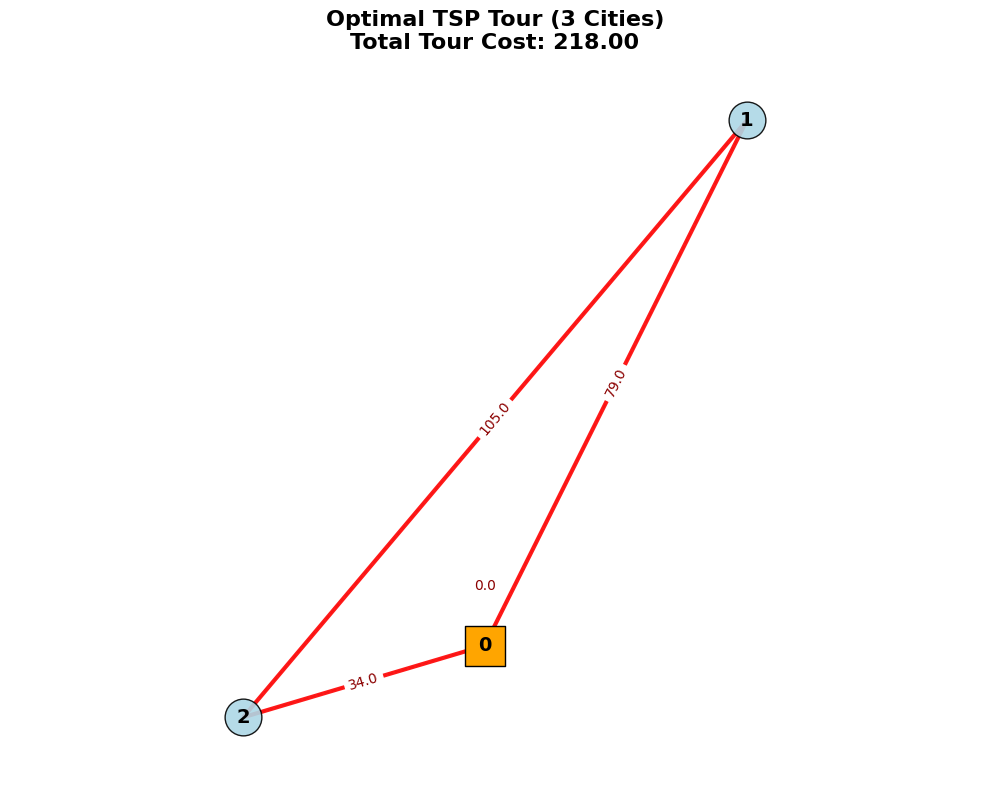


📍 Tour Summary:
   Start City: 0
   Path: 0 → 1 → 2 → 0
   Total Distance: 218.00



In [358]:
G = tsp.graph
pos = {i: G.nodes[i]["pos"] for i in G.nodes()}
visualize_tsp_solution(G, pos, tour, title="Optimal TSP Tour (3 Cities)")

### **From Quadratic Program to QUBO**

Quantum computers solve problems formulated as Hamiltonians. A common step is to first convert the problem into a **Quadratic Unconstrained Binary Optimization (QUBO)** problem. This format represents the problem as a single quadratic equation to be minimized, without any constraints.


In [359]:
problem = tsp.to_quadratic_program()
print(problem.prettyprint())

Problem name: TSP

Minimize
  79*x_0_0*x_1_1 + 79*x_0_0*x_1_2 + 34*x_0_0*x_2_1 + 34*x_0_0*x_2_2
  + 79*x_0_1*x_1_0 + 79*x_0_1*x_1_2 + 34*x_0_1*x_2_0 + 34*x_0_1*x_2_2
  + 79*x_0_2*x_1_0 + 79*x_0_2*x_1_1 + 34*x_0_2*x_2_0 + 34*x_0_2*x_2_1
  + 105*x_1_0*x_2_1 + 105*x_1_0*x_2_2 + 105*x_1_1*x_2_0 + 105*x_1_1*x_2_2
  + 105*x_1_2*x_2_0 + 105*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [360]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: - 5236 x_0_0 - 5236 x_0_1 - 5236 x_0_2 - 5236 x_1_0 - 5236 x_1_1
      - 5236 x_1_2 - 5236 x_2_0 - 5236 x_2_1 - 5236 x_2_2 + [ 5236 x_0_0^2
      + 5236 x_0_0*x_0_1 + 5236 x_0_0*x_0_2 + 5236 x_0_0*x_1_0 + 158 x_0_0*x_1_1
      + 158 x_0_0*x_1_2 + 5236 x_0_0*x_2_0 + 68 x_0_0*x_2_1 + 68 x_0_0*x_2_2
      + 5236 x_0_1^2 + 5236 x_0_1*x_0_2 + 158 x_0_1*x_1_0 + 5236 x_0_1*x_1_1
      + 158 x_0_1*x_1_2 + 68 x_0_1*x_2_0 + 5236 x_0_1*x_2_1 + 68 x_0_1*x_2_2
      + 5236 x_0_2^2 + 158 x_0_2*x_1_0 + 158 x_0_2*x_1_1 + 5236 x_0_2*x_1_2
      + 68 x_0_2*x_2_0 + 68 x_0_2*x_2_1 + 5236 x_0_2*x_2_2 + 5236 x_1_0^2
      + 5236 x_1_0*x_1_1 + 5236 x_1_0*x_1_2 + 5236 x_1_0*x_2_0 + 210 x_1_0*x_2_1
      + 210 x_1_0*x_2_2 + 5236 x_1_1^2 + 5236 x_1_1*x_1_2 + 210 x_1_1*x_2_0
      + 5236 x_1_1*x_2_1 + 210 x_1_1*x_2_2 + 5236 x_1_2^2 + 210 x_1_2*x_2_0
      + 210 x_1_2*x_2_1 + 5236 x_1_2*x_2_2 + 5236 x_2_0^2 + 5236 x

In [361]:
num_vars = qubo.get_num_vars()
print(f"Number of variables in QUBO: {num_vars}")


Number of variables in QUBO: 9


### **Mapping the QUBO to an Ising Hamiltonian**

The VQE algorithm works by finding the minimum energy (eigenvalue) of a Hamiltonian. We now convert our QUBO problem into an **Ising Hamiltonian**. This Hamiltonian is an operator that can be measured on a quantum computer. Each binary variable in the QUBO is mapped to a qubit.

The conversion gives us two components:

- `qubitOp`: The Ising Hamiltonian, represented as a sum of Pauli operators (Z, ZZ).

- `offset`: A constant energy shift that we'll add back to our final result.

In [363]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 8181.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1365.5 +0.j, -1365.5 +0.j, -1365.5 +0.j, -1401.  +0.j, -1401.  +0.j,
 -1401.  +0.j, -1378.5 +0.j, -1378.5 +0.j, -1378.5 +0.j,   654.5 +0.j,
   654.5 +0.j,   654.5 +0.j,    19.75+0.j,    19.75+0.j,   654.5 +0.j,
     8.5 +0.j,     8.5 +0.j,   654.5 +0.j,    19.75+0.j,   654.5 +0.j,
    19.75+0.j,     8.5 +0.j,   654.5 +0.j,     8.5 +0.j,    

### **The Quantum Approximate Optimization Algorithm (QAOA)**

QAOA is another hybrid quantum-classical algorithm designed for optimization problems. It uses a special type of ansatz circuit that alternates between two operators: a **cost operator** (derived from our problem Hamiltonian) and a **mixer operator**.

The goal is to find the optimal parameters (angles) for these operators that prepare a quantum state with the lowest possible energy.



#### **The QAOA Ansatz**

The `QAOAAnsatz` circuit is constructed directly from our problem's cost operator (`qubitOp`). The `reps` parameter defines how many times the cost and mixer layers are repeated, which affects the circuit's complexity and potential accuracy.

Let's visualize the structure of our QAOA ansatz circuit with `reps=1`.

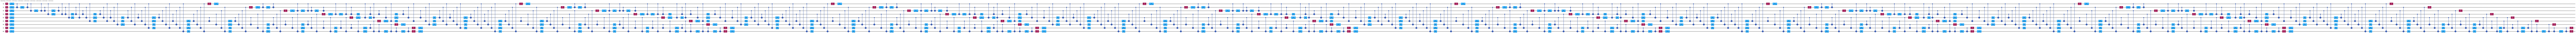

In [364]:
reps = 8
circuit = QAOAAnsatz(cost_operator=qubitOp, reps=reps)
circuit = circuit.decompose(reps=3)
circuit.draw('mpl',fold=-1)

#### Executing the QAOA Algorithm

To run QAOA, we need to set up the classical optimization loop.

- **Initial Parameters:** We choose an initial set of parameters (beta and gamma angles) for the ansatz. A common starting point is `pi` for gamma and `pi/2` for beta, repeated for each rep.

- **Cost Function:** We define a `cost_func_estimator` that takes the parameters, builds the QAOA circuit, and uses the `Estimator` to calculate the expectation value (energy) of the Hamiltonian. This energy is what the classical optimizer will minimize. We also store the objective function values at each step to plot the convergence.

- **Classical Optimizer:** We use the `COBYLA` optimizer from SciPy to find the optimal beta and gamma angles that minimize the energy.

Here are our initial parameters:

In [365]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta]*reps
print(init_params)

[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


This is the cost function that the optimizer will call:

In [366]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

Now, we execute the optimization loop.

In [432]:
objective_func_vals = [] # Store the objective function values

result = minimize(
    cost_func_estimator,
    init_params,
    args= (circuit, qubitOp, estimator),
    method="cobyla", # you can also use 'SLSQP' or 'L-BFGS-B'
    options={'maxiter': 5000, 'disp': True},
    tol=1e-6
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3962.07861328125
       x: [ 4.193e+00  1.526e+00 ...  3.210e+00  1.516e+00]
    nfev: 223
   maxcv: 0.0


The optimizer has found the optimal parameters (according to QAOA) . Let's plot the objective function value at each iteration to see how the algorithm converged to the solution.

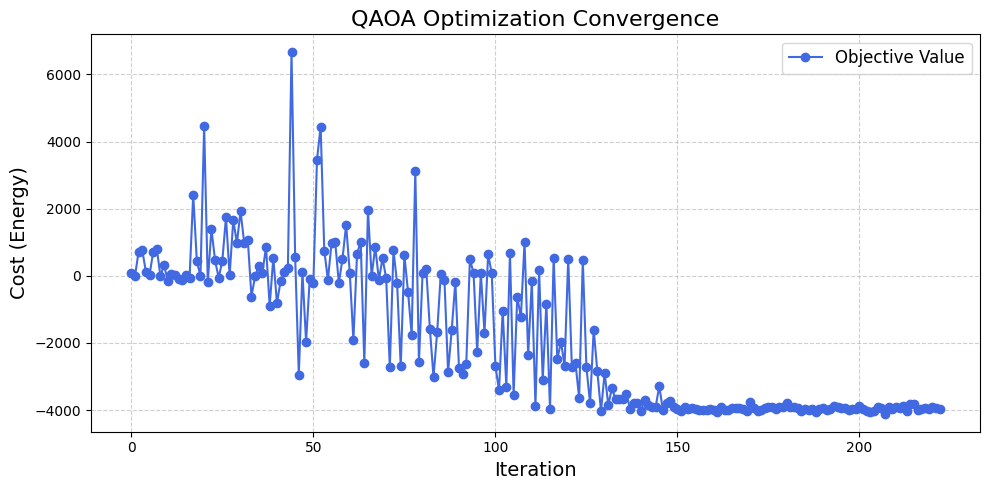

In [433]:
plt.figure(figsize=(10, 5))
plt.plot(objective_func_vals, marker='o', linestyle='-', color='royalblue', label='Objective Value')
plt.title("QAOA Optimization Convergence", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost (Energy)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



### **Post-Processing: Sampling the Solution**

With the optimal parameters found, we now create the final QAOA circuit. We then add measurements and use the `Sampler` primitive to execute the circuit many times (shots) and obtain a probability distribution of the possible solution bitstrings.

The bitstring with the highest probability is our candidate for the optimal solution.

In [434]:
# Assign the optimal parameters to the ansatz
optimal_circuit = circuit.assign_parameters(result.x)
optimal_circuit.measure_all()

# Run the sampler job
pub = (optimal_circuit,)
job = sampler.run([pub], shots=int(1e6))

# Get the counts
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()

# Normalize the counts to get a probability distribution
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

Let's find the most likely bitstring from the final distribution.

In [435]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 1, 0, 0, 0, 1]


In [436]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result TSP:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result TSP: [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Result value: 218.0
Feasible: True


In [437]:
print("="*40)
print("🔎 Best Known Classical Solution")
print("="*40)
print(f"  • Total Value:        {m.objective_value}")

print()

print("="*40)
print("⚛️  VQE (Quantum) Solution")
print("="*40)
print(f"  • Total Value:        {cost}")
print(f"  • Solution Vector:    {result}")
print(f"  • Feasible:           {feasible}")

if feasible:
    optimality_gap = 100 * (m.objective_value - cost) / m.objective_value
    print(f"  • Optimality Gap:     {optimality_gap:.2f}%")
else:
    print("  • Note: Quantum solution is not feasible.")

print("\n" + "-"*40)
if feasible:
    if abs(cost - m.objective_value) < 1e-6:
        print("✅ Quantum solution matches the classical optimum!")
    else:
        print("ℹ️  Quantum solution is suboptimal compared to classical.")
else:
    print("❌ Quantum solution is not feasible.")
print("-"*40)

🔎 Best Known Classical Solution
  • Total Value:        218.0

⚛️  VQE (Quantum) Solution
  • Total Value:        218.0
  • Solution Vector:    [1. 0. 0. 0. 1. 0. 0. 0. 1.]
  • Feasible:           True
  • Optimality Gap:     0.00%

----------------------------------------
✅ Quantum solution matches the classical optimum!
----------------------------------------


Since QAOA is a heuristic algorithm, it's a good practice to examine the top few most likely outcomes.

In [438]:
# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []

# Define column widths
col_widths = {
    "Rank": 5,
    "Probability": 12,
    "TSP Solution": 23,
    "Value": 9,
    "Feasible": 10,
    "Optimality Gap (%)": 20
}

# Table header with aligned columns
header = (
    f"{'Rank':<{col_widths['Rank']}} | "
    f"{'Probability':<{col_widths['Probability']}} | "
    f"{'TSP Solution':<{col_widths['TSP Solution']}} | "
    f"{'Value':<{col_widths['Value']}} | "
    f"{'Feasible':<{col_widths['Feasible']}} | "
    f"{'Optimality Gap (%)':<{col_widths['Optimality Gap (%)']}}"
)
print("\nTop 4 Most Probable Solutions from VQE Measurement:\n")
print(header)
print("=" * len(header))

for rank, idx in enumerate(top_4_indices, 1):
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    interpreted = converter.interpret(bitstring)
    value = problem.objective.evaluate(interpreted)
    feasible = problem.get_feasibility_info(interpreted)[0]
    if feasible and m.objective_value != 0:
        optimality_gap = 100 * (m.objective_value - value) / m.objective_value
        gap_str = f"{optimality_gap:>18.2f}"
    else:
        gap_str = f"{'N/A':>{col_widths['Optimality Gap (%)']}}"
    print(
        f"{rank:<{col_widths['Rank']}} | "
        f"{values[idx]:<{col_widths['Probability']}.6f} | "
        f"{str(interpreted):<{col_widths['TSP Solution']}} | "
        f"{value:<{col_widths['Value']}} | "
        f"{str(feasible):<{col_widths['Feasible']}} | "
        f"{gap_str}"
    )
print("=" * len(header))



Top 4 Most Probable Solutions from VQE Measurement:

Rank  | Probability  | TSP Solution            | Value     | Feasible   | Optimality Gap (%)  
1     | 0.034796     | [1. 0. 0. 0. 1. 0. 0. 0. 1.] | 218.0     | True       |               0.00
2     | 0.034758     | [1. 0. 0. 0. 0. 1. 0. 1. 0.] | 218.0     | True       |               0.00
3     | 0.034750     | [0. 0. 1. 0. 1. 0. 1. 0. 0.] | 218.0     | True       |               0.00
4     | 0.034740     | [0. 1. 0. 0. 0. 1. 1. 0. 0.] | 218.0     | True       |               0.00
